
# 中学生向け：最小二乗法と勾配降下でつくる線形回帰（睡眠と日中活動）

このノートでは、**睡眠時間**（x）と **日中活動スコア**（y）の関係を、**直線**で表す「線形回帰」を、
**最小二乗法のコスト関数**と**勾配降下法**で学習して体験します。

https://chatgpt.com/share/689f2e6c-9150-8000-87d4-8ffc2a798960

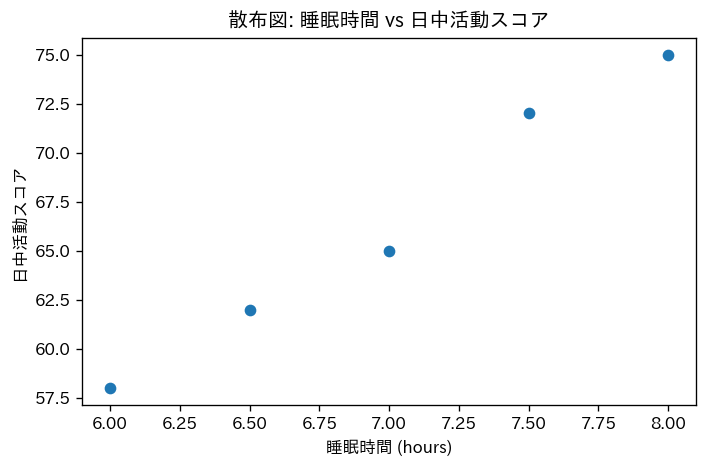

In [7]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from pathlib import Path
from ace_tools_open import display_dataframe_to_user

df = pd.DataFrame({
    "sleep_hours": [6.5, 7.0, 7.5, 8.0, 6.0],
    "activity_score": [62, 65, 72, 75, 58],
})
df.columns = [c.strip() for c in df.columns]
# display_dataframe_to_user("Sleep vs Activity Data", df.copy())

X = df["sleep_hours"].to_numpy().astype(float)
y = df["activity_score"].to_numpy().astype(float)
m = len(X)

plt.figure(figsize=(6,4), dpi=120)
plt.scatter(X, y)
plt.xlabel("睡眠時間 (hours)")
plt.ylabel("日中活動スコア")
plt.title("散布図: 睡眠時間 vs 日中活動スコア")
plt.tight_layout()
plt.show()



## 数学のイメージ
- 直線の式（仮説）: $h_{w,b}(x) = wx + b$  … **傾き** $w$ と **切片** $b$ を探します。
- コスト関数: $J(w, b) = \tfrac{1}{2m} \sum (h_{w,b}(x_i) - y_i)^2$  
  各点から直線までの**縦方向の距離**（誤差）を二乗して平均したもの。大きい誤差をより強く罰します。
- 勾配降下: $w, b$ を少しずつ動かして、$J$ が**一番小さくなる場所**まで「坂道を下る」。


勾配降下法の結果: w ≈ 8.800, b ≈ 4.800


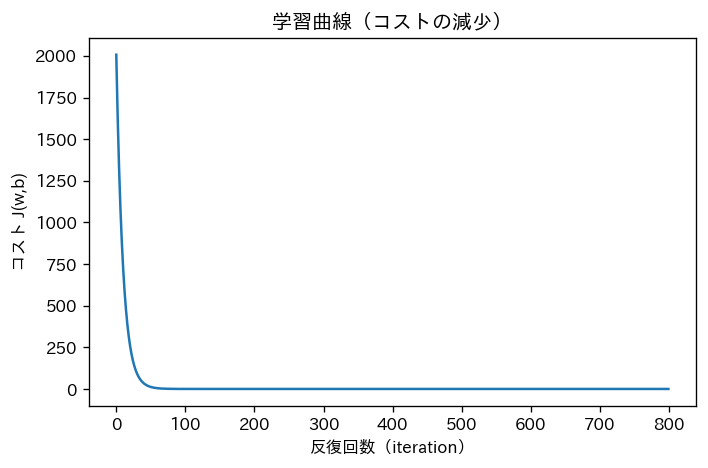

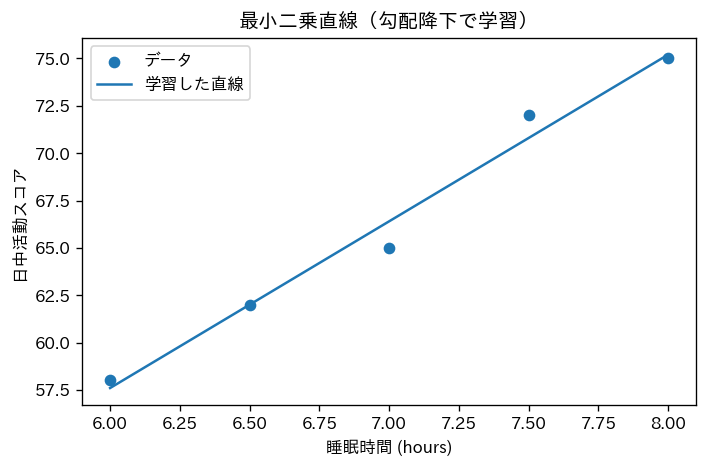

決定係数 R^2 = 0.982


In [8]:

def cost(w, b, X, y):
    preds = w * X + b
    residuals = preds - y
    return (residuals @ residuals) / (2.0 * len(X))

def gradients(w, b, X, y):
    m = len(X)
    preds = w * X + b
    err = preds - y
    dw = (err * X).sum() / m
    db = err.sum() / m
    return dw, db

# 特徴量の標準化（内部計算用）
mu_x = X.mean()
sigma_x = X.std(ddof=0) if X.std(ddof=0) > 0 else 1.0
Z = (X - mu_x) / sigma_x

def train_gradient_descent(Z, y, alpha=0.05, iters=800):
    w, b = 0.0, 0.0
    history = {"w": [], "b": [], "J": []}
    for t in range(iters):
        dw, db = gradients(w, b, Z, y)
        w -= alpha * dw
        b -= alpha * db
        history["w"].append(w)
        history["b"].append(b)
        history["J"].append(cost(w, b, Z, y))
    return w, b, history

w_z, b_z, hist = train_gradient_descent(Z, y)
w_hat = w_z / sigma_x
b_hat = b_z - (w_z * mu_x / sigma_x)
print(f"勾配降下法の結果: w ≈ {w_hat:.3f}, b ≈ {b_hat:.3f}")

plt.figure(figsize=(6,4), dpi=120)
plt.plot(hist["J"])
plt.xlabel("反復回数（iteration）")
plt.ylabel("コスト J(w,b)")
plt.title("学習曲線（コストの減少）")
plt.tight_layout()
plt.show()

x_line = np.linspace(X.min(), X.max(), 100)
y_line = w_hat * x_line + b_hat

plt.figure(figsize=(6,4), dpi=120)
plt.scatter(X, y, label="データ")
plt.plot(x_line, y_line, label="学習した直線")
plt.xlabel("睡眠時間 (hours)")
plt.ylabel("日中活動スコア")
plt.title("最小二乗直線（勾配降下で学習）")
plt.legend()
plt.tight_layout()
plt.show()

# R^2
y_pred = w_hat * X + b_hat
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
print(f"決定係数 R^2 = {r2:.3f}")



## 検算：解析解（正規方程式）
1 変数の線形回帰では、
\[
w = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}, \quad
b = \bar{y} - w\,\bar{x}
\]
で一発で求まります。勾配降下の結果と近いはずです。


In [9]:

x_mean = X.mean()
y_mean = y.mean()
num = np.sum((X - x_mean) * (y - y_mean))
den = np.sum((X - x_mean) ** 2)
w_closed = num / den if den != 0 else 0.0
b_closed = y_mean - w_closed * x_mean
print(f"解析解: w = {w_closed:.3f}, b = {b_closed:.3f}")


解析解: w = 8.800, b = 4.800



## コスト関数の地形を見てみよう（等高線）
「ボウル」の底が最小値。勾配降下は底へ向かって進みます。


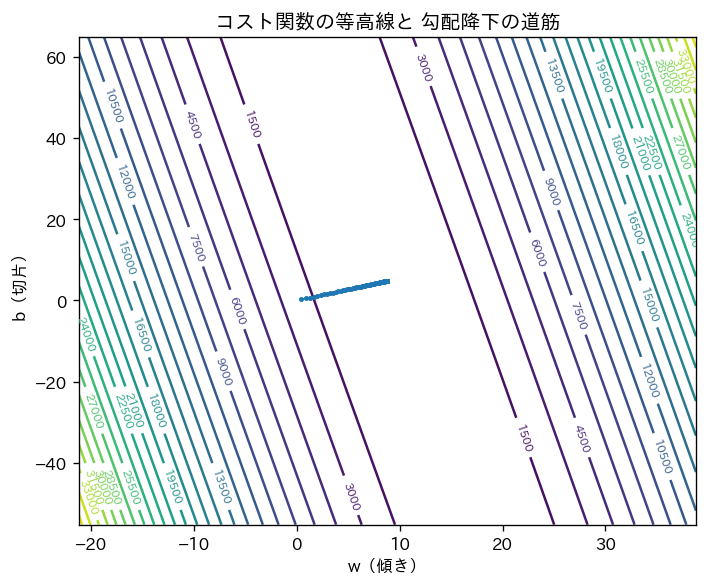

In [10]:

# 等高線図
w_vals = np.linspace(w_hat - 30, w_hat + 30, 180)
b_vals = np.linspace(b_hat - 60, b_hat + 60, 180)
W, B = np.meshgrid(w_vals, b_vals)

def grid_cost(W, B, X, y):
    preds = W[..., None] * X + B[..., None]
    res = preds - y
    return (res ** 2).mean(axis=-1) / 2.0

J_grid = grid_cost(W, B, X, y)

path_w = np.array(hist["w"]) / sigma_x
path_b = np.array(hist["b"]) - (np.array(hist["w"]) * mu_x / sigma_x)

plt.figure(figsize=(6,5), dpi=120)
CS = plt.contour(W, B, J_grid, levels=30)
plt.clabel(CS, inline=True, fontsize=7)
plt.plot(path_w, path_b, marker="o", linewidth=1, markersize=2)
plt.xlabel("w（傾き）")
plt.ylabel("b（切片）")
plt.title("コスト関数の等高線と 勾配降下の道筋")
plt.tight_layout()
plt.show()



## 予測してみよう
学習した $w, b$ を使って、たとえば 6h, 7h, 8h のときのスコアを予測。


In [11]:

def predict(sleep_hours):
    return w_hat * np.asarray(sleep_hours) + b_hat

print(predict([6.0, 7.0, 8.0]))


[57.6 66.4 75.2]
